# Coming from TensorFlow to NengoDL

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for
people who are familiar with TensorFlow and looking to learn more about neuromorphic
modelling with NengoDL.  For the other approach, users familiar with Nengo looking to
learn how to use NengoDL, check out [this
tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

If you are familiar with Keras you may also be interested in
[KerasSpiking](https://www.nengo.ai/keras-spiking/), a companion project to NengoDL
that has a more minimal feature set, but integrates even more transparently with the
Keras API. See [this page](https://www.nengo.ai/keras-spiking/nengo-dl-comparison.html)
for a more detailed comparison between the two projects.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you
would want to use it.  Nengo is a tool for constructing and simulating neural networks.
That is, to some extent, the same purpose as TensorFlow (and its higher level API,
Keras).  For example, here is how we might build a simple two layer auto-encoder network
in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,)) # What is this notation for size? No second argument? shape expects a tuple, we only pass in one dimension

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform() # What is a kernel initializer? This is the filter that the kernel applies. This is strictly for starting values
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [4]:
with nengo.Network() as auto_net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot()) # Is this parallel to the kernel initializer? The transform occurs before a function is applied

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and
the creation of the connections between layers.  This is because the connection
structure in Nengo networks often has a lot more state and general complexity than in
typical deep learning networks, so it is helpful to be able to control it independently
(we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data
from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we
want to collect the activities of those neurons when the simulation is running.  You can
think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality
available, but we will focus on the features most familiar or relevant to those coming
from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the
Nengo-specific [documentation](https://www.nengo.ai/nengo/) and
[examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [5]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
out = model.predict(np.ones((minibatch_size, n_in)))
print(out.shape)

(50, 784)


Again, accomplishing the same thing in Nengo bears many similarities.  We create a
`Simulator` and call `sim.predict`:

In [6]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
    out = sim.predict(np.ones((minibatch_size, 1, n_in)))
    print(out[p_c].shape)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
(50, 1, 784)


One difference you may note is the extra dimension with size 1 in the shape of the Nengo
inputs and outputs.  This represents the time dimension; in this example we're only
running for a
single timestep, which is why it has size 1, but this could be used to provide different
input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are
fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an
abstract set of computations, in Nengo we (almost) always think of the graph as
representing a stateful neural simulation, where values are accumulated, updated, and
communicated over time.  This is not to say there is no overlap (we can create
TensorFlow simulations that execute over time, and we can create Nengo simulations
without temporal dynamics), but this is a different way of thinking about computations
that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily
designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic
networks include features drawn from biological neural networks, in an effort to
understand or recreate the functionality of biological brains.  Note that these models
fall on a spectrum with standard artificial neural networks, with different approaches
incorporating different biological features.  But in general the structure and
parameterization of these networks often differs significantly from standard deep
network architectures.

We touched on this above in the discussion of temporality, which is one common feature
of neuromorphic networks.  Another common characteristic is the use of more complicated
neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like
`relu`) that output a continuous value, spiking neurons communicate via discrete bursts
of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll
use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps`
(or `sim.run`) is a standard Nengo Simulator execution function (as opposed to
`sim.predict`, which is specific to NengoDL).  We could use either one, but you will
probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in
this case is that results will be stored in the `sim.data` dictionary, as opposed to
being returned directly from `sim.predict`.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:02                                                 


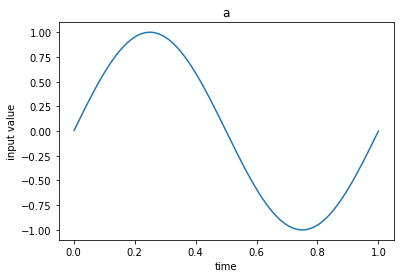

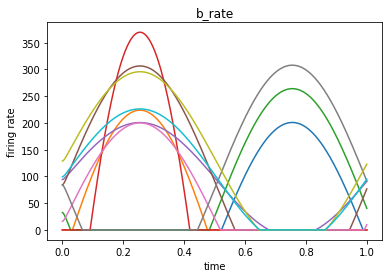

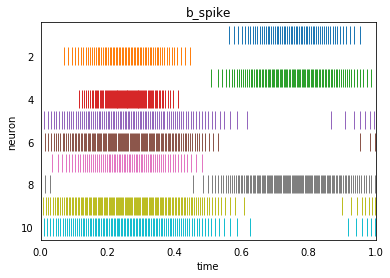

In [7]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))

    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)

    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)

    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)

with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")

plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike")
plt.show()

Each neuron responds to the input signal differently due to the random parameterization
in the network (e.g. connection weights and biases).  We have matched the
parameterization in the rate and spiking ensembles so that it is easier to see the
parallels.

Note that the same information is being represented in the two ensembles.  For example,
when the second neuron (orange) is outputting a high continuous value (in the second
graph), the corresponding spiking neuron is outputting more discrete spikes (orange
lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic
filters.  This is inspired by a biological feature where discrete spikes induce a
continuous electrical waveform in the receiving neuron, at the synapse (the point where
the two neurons connect).  But computationally we can think of this simply as applying a
filter to the spiking signal.

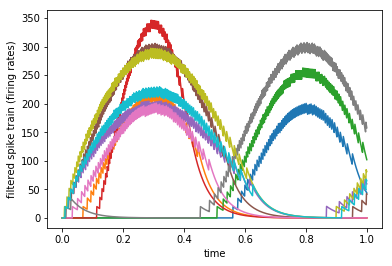

In [8]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)")
plt.show()

We can see how the spike trains, when viewed through a synaptic filter, approximate the
continuous rate values in the second graph above.

In this example we have computed the filtered signal manually for demonstration
purposes, but in a typical Nengo model these synaptic filters are applied throughout the
model, on the `Connection` objects.  For example, the above filtering would be
equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective
of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and
Nengo from a standard deep network background.  Although spiking neurons seem like a
radically different paradigm, they can compute and communicate the same information as
their rate counterparts.  But note that this only makes sense when we think of the
network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the
documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete
list).  These neuron models have various different behaviours, and managing their
parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly
work together.  Thus one important feature is the ability to write TensorFlow code
directly, and insert it into a Nengo network.  This allows us to use whichever framework
is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us
to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the
rest of a Nengo model.  The TensorFlow code is written in a function that takes
`tf.Tensors` as input, applies the desired manipulations through TensorFlow operations,
and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for
constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose
we want to apply batch normalization to the output of one of the Nengo ensembles.  There
is no built-in way to do batch normalization in Nengo, so we can instead turn to
TensorFlow for this part of the model.

In [9]:
with net:
    batch_norm = nengo_dl.Layer(tf.keras.layers.BatchNormalization(momentum=0.9))(
        b_rate.neurons
    )
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`,
except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this
case, and we can add Probes or Connections to `batch_norm` in the same way as any other
Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and
`Connection`; the above is equivalent to

In [10]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9),
        shape_in=(10,),
        pass_time=False,
    )
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write
ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the
current simulation time and `x` is the value of any Connections incoming to the
TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have
shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the
`TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The
`TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,)
+ shape_out`, where `shape_out` is the output dimensionality of the node (dependent on
the manipulations applied to the inputs `x`).  We could explicitly specify
`shape_out=(10,)` in the above example, or if we don't specify the output shape it will
be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [11]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1])

    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)

        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)

    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), shape_out=(2,))
    nengo.Connection(a, b, synapse=None)

    p = nengo.Probe(b)

with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
TensorNode input:
t: 0.001
x: [[0.5 -0.1]]
t: 0.002
x: [[0.5 -0.1]]
t: 0.003
x: [[0.5 -0.1]]
t: 0.004
x: [[0.5 -0.1]]
t: 0.00500000035
x: [[0.5 -0.1]]
t: 0.006
x: [[0.5 -0.1]]
t: 0.007
x: [[0.5 -0.1]]
t: 0.008
x: [[0.5 -0.1]]
t: 0.00900000054
x: [[0.5 -0.1]]
t: 0.0100000007
x: [[0.5 -0.1]]
TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation
time over the 10 timesteps we executed, and `x` contains the value of the input Node
that we connected to the TensorNode.  And we can see in the probe data that the
TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This
can be useful, for example, if the TensorNode requires internal parameters (which should
be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [12]:
with nengo.Network() as net:

    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))

        def call(self, inputs):
            return inputs * self.w

    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), pass_time=False)

More details on TensorNode usage can be found in [the user
guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms,
through the `Simulator.fit` function.  Returning to the autoencoder examples from the
beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [13]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Epoch 1/2
1875/1875 [==============================] - 5s 3ms/step - loss: 1761.3287
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 849.8817


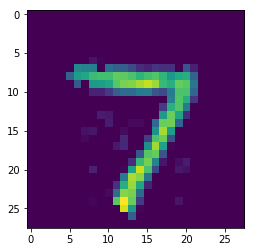

In [14]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
model.evaluate(test_data, test_data)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)))
plt.show()

Before running the same training in NengoDL, we'll change the Nengo model parameters to
more closely match the TensorFlow network (we omitted these details in the original
presentation to keep things simple).

In [15]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are
essentially temporal, so data is described over time (indicating what the inputs/targets
should be on each simulation timestep).  So instead of the data having shape
`(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll
just be training for a single timestep, but we still need to add that extra axis with
length 1.

In [16]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training (note: the
results will not match exactly due to different random initializations):

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/2
1200/1200 [==============================] - 12s 9ms/step - loss: 1975.3283 - probe_loss: 1975.3283
Epoch 2/2
200/200 [==============================] - 1s 5ms/step - loss: 898.8473 - probe_loss: 898.8473


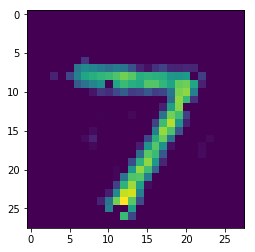

In [17]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)))
    plt.show()

More details on using `sim.fit` can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering
Framework (NEF).  This uses linear least-squares optimization to solve for optimal
connection weights analytically, rather than using an iterative gradient-descent based
algorithm.  The advantage of the NEF is that it is very fast and general (for example,
it does not require the network to be differentiable).  The disadvantage is that it
optimizes each set of connection weights individually (i.e., it cannot jointly optimize
across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a
`nengo.Connection`.  This specifies the function that we would like those connection
weights to approximate.  In addition, in previous examples you may have noticed that we
were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using
`ensemble.neurons` specifies that we want to form a direct connection between ensemble
neurons, without applying the NEF optimization.  So when we want to use the `function`
argument, the `Connection` source object should be an `ensemble`, not
`ensemble.neurons`.  For example, we could use the NEF to create a network to
approximate the function $sin(x^2)$:

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:02                                                 


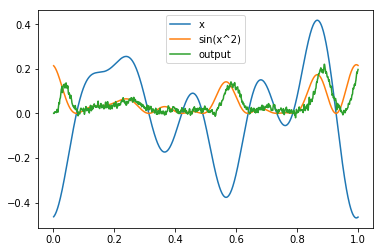

In [18]:
with nengo.Network(seed=0) as net:
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))

    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)

    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)

    # output node
    outpt = nengo.Node(size_in=1)

    # connect input to first ensemble
    nengo.Connection(inpt, ens0)

    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)

    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)

    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt, synapse=0.005)

with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

The NEF optimization can be used in combination with the deep learning optimization
methods.  For example, we could optimize some parameters with the NEF and others with
`sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).
Or we could initialize each set of connection weights individually with the NEF, and
then further refine them with end-to-end training via `sim.fit`.  As always, the overall
theme is that NengoDL allows us to use whichever method is most appropriate for a
particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a
deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic
networks quickly/efficiently.  However, often it is difficult to program this custom
hardware, and it requires writing custom code for each neuromorphic platform.  One of
the primary design goals of Nengo is to alleviate these challenges, by providing a
single API that can be used to build networks across many different neuromorphic
platforms.

The idea is that the front-end network construction code is the same (`Networks`,
`Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own
`Simulator` class (the back-end) that compiles and executes that network definition for
some compute platform.  This provides a consistent interface so that we only need to
write code once and can then run that network on novel hardware platforms with no
additional effort.  For example, we could take the network from above and simulate it on
different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

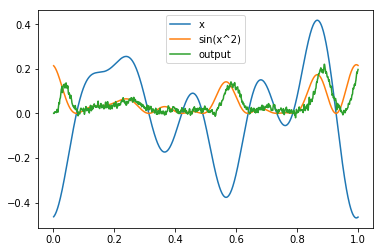

In [19]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

# run on Loihi neuromorphic hardware
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo-labs/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

We have commented out the different backends above because they require extra
installation steps, but if you are running this example yourself you can install any of
those backends (or more) and uncomment that code to see the same network running on that
new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end
(among other things); it takes a standard Nengo network, and simulates it using
TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate
NengoDL's deep learning functionality into any other Nengo back-end.  We build our
Network, optimize it in NengoDL, save the optimized model parameters back into the
Network definition, and then simulate that optimized Network in a different back-end.
See [this example in
nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a
spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL,
including network construction, execution, and optimization.  We have also discussed how
to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the
unique features of Nengo (such as NEF optimization and neuromorphic cross-platform
execution).  However, there is much more functionality in NengoDL than we are able to
introduce here; check out the [user
guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other
examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you
would like more information on how NengoDL is implemented under the hood using
TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).